<a href="https://colab.research.google.com/github/imanf18/Model2_MiniProject_HAM10000/blob/main/Model2_Miniproject2_HAM10000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os

from PIL import Image
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display

2. Loading and Understanding the Dataset

In [2]:
pip install kaggle

In [3]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [00:47<00:00, 182MB/s]
100% 5.20G/5.20G [00:47<00:00, 118MB/s]


In [4]:
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [5]:
import subprocess

# Buat folder baru
subprocess.run(["mkdir", "/content/skin-cancer-mnist-ham10000"])

# Pindahkan dua folder ke dalam folder baru
subprocess.run(["mv", "/content/HAM10000_images_part_1", "/content/skin-cancer-mnist-ham10000/"])
subprocess.run(["mv", "/content/HAM10000_images_part_2", "/content/skin-cancer-mnist-ham10000/"])

CompletedProcess(args=['mv', '/content/HAM10000_images_part_2', '/content/skin-cancer-mnist-ham10000/'], returncode=0)

In [6]:
# Setting data directory
data_directory = os.path.join("/content/")
os.listdir(data_directory)# Loading HAM10000_meatdata.csv
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))

3. Creating a Dictionary for Image Path and Lesion Type

In [7]:
# Creating dictionary for image path, and lesion type
# Adding images from both the folders
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))));
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
557,HAM_0005913,ISIC_0028640,bkl,histo,70.0,male,back,Benign keratosis-like lesions (bkl),/content/ham10000_images_part_1/ISIC_0028640.jpg,"[[[145, 110, 117], [139, 101, 103], [157, 123,..."
4329,HAM_0004425,ISIC_0025147,nv,follow_up,40.0,female,lower extremity,Melanocytic nevi (nv),/content/ham10000_images_part_1/ISIC_0025147.jpg,"[[[239, 161, 164], [240, 160, 165], [242, 162,..."
2839,HAM_0004365,ISIC_0028719,bcc,histo,80.0,male,face,Basal cell carcinoma (bcc),/content/ham10000_images_part_1/ISIC_0028719.jpg,"[[[106, 81, 85], [112, 75, 80], [116, 73, 76],..."
6287,HAM_0003185,ISIC_0030430,nv,follow_up,40.0,male,foot,Melanocytic nevi (nv),/content/ham10000_images_part_2/ISIC_0030430.jpg,"[[[246, 167, 189], [247, 168, 192], [247, 170,..."
1975,HAM_0000888,ISIC_0025085,mel,histo,75.0,male,upper extremity,Melanoma (mel),/content/ham10000_images_part_1/ISIC_0025085.jpg,"[[[186, 149, 162], [189, 155, 176], [189, 149,..."


4. Exploratory Data Analysis (EDA)

In [8]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=data['sex'].value_counts().index,
            y=data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=data['localization'].value_counts().index,
            y=data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=data['dx'].value_counts().index.map(lesion_type_dict.get),
            y=data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)

fig.show()

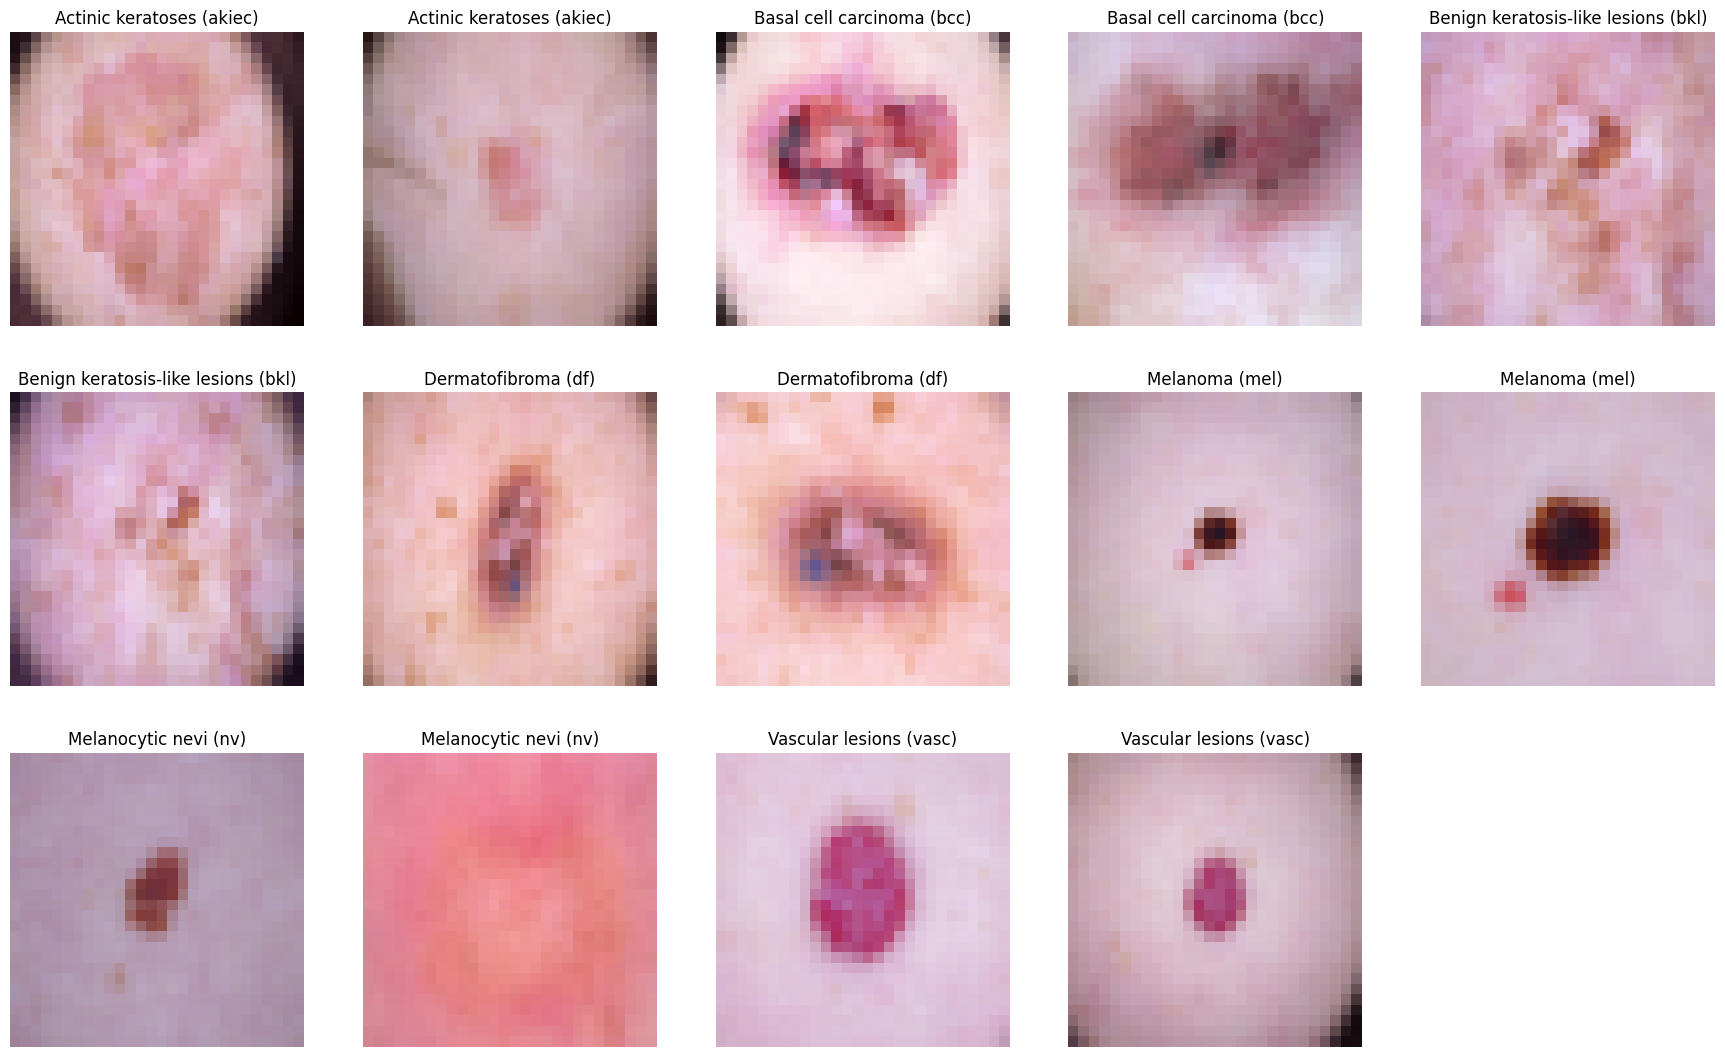

In [9]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show()

5. Prepocessing

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   cell_type     10015 non-null  object 
 8   path          10015 non-null  object 
 9   image_pixel   10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.5+ KB


In [11]:
# Checking null values
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
cell_type        0
path             0
image_pixel      0
dtype: int64

In [12]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')# Categorically encoding label of the images
data['label'] = data['dx'].map(reverse_label_mapping.get)
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
2151,HAM_0001744,ISIC_0032476,mel,histo,60,male,back,Melanoma (mel),/content/ham10000_images_part_2/ISIC_0032476.jpg,"[[[132, 87, 87], [137, 91, 89], [139, 92, 90],...",1
9024,HAM_0004479,ISIC_0032090,nv,histo,45,female,ear,Melanocytic nevi (nv),/content/ham10000_images_part_2/ISIC_0032090.jpg,"[[[219, 194, 180], [219, 193, 177], [219, 191,...",0
5263,HAM_0003486,ISIC_0029494,nv,follow_up,50,female,abdomen,Melanocytic nevi (nv),/content/ham10000_images_part_2/ISIC_0029494.jpg,"[[[223, 131, 120], [226, 134, 124], [227, 135,...",0
3262,HAM_0000327,ISIC_0026682,nv,follow_up,50,female,trunk,Melanocytic nevi (nv),/content/ham10000_images_part_1/ISIC_0026682.jpg,"[[[229, 147, 164], [230, 148, 169], [231, 144,...",0
7549,HAM_0001133,ISIC_0032980,nv,histo,20,female,back,Melanocytic nevi (nv),/content/ham10000_images_part_2/ISIC_0032980.jpg,"[[[159, 124, 149], [160, 124, 152], [160, 123,...",0


6. Data Augmentation

In [13]:
import time

start_time = time.time()

# Code block 1

end_time = time.time()
execution_time_block1 = end_time - start_time
print("Execution time for block 1:", execution_time_block1, "seconds")

start_time = time.time()

# Code block 2

end_time = time.time()
execution_time_block2 = end_time - start_time
print("Execution time for block 2:", execution_time_block2, "seconds")

Execution time for block 1: 5.5789947509765625e-05 seconds
Execution time for block 2: 5.269050598144531e-05 seconds


In [14]:

# Sorting data by label and resetting index
data = data.sort_values('label')
data = data.reset_index(drop=True)

# Getting indices for each label
index1 = data[data['label'] == 1].index.values
index2 = data[data['label'] == 2].index.values
index3 = data[data['label'] == 3].index.values
index4 = data[data['label'] == 4].index.values
index5 = data[data['label'] == 5].index.values
index6 = data[data['label'] == 6].index.values

# Creating DataFrames based on indices
df_index1 = data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = data.iloc[int(min(index3)):int(max(index3)+1)]
df_index4 = data.iloc[int(min(index4)):int(max(index4)+1)]
df_index5 = data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = data.iloc[int(min(index6)):int(max(index6)+1)]

# Replicating rows in DataFrames
df_index1 = pd.concat([df_index1] * 4, ignore_index=True)
df_index2 = pd.concat([df_index2] * 4, ignore_index=True)
df_index3 = pd.concat([df_index3] * 11, ignore_index=True)
df_index4 = pd.concat([df_index4] * 17, ignore_index=True)
df_index5 = pd.concat([df_index5] * 45, ignore_index=True)
df_index6 = pd.concat([df_index6] * 52, ignore_index=True)

# Concatenating all DataFrames
frames = [data, df_index1, df_index2, df_index3, df_index4, df_index5, df_index6]
final_data = pd.concat(frames)

# Visualizing data distribution
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=final_data['sex'].value_counts().index,
            y=final_data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=final_data['localization'].value_counts().index,
            y=final_data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=final_data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=final_data['dx'].value_counts().index.map(lesion_type_dict.get),
            y=final_data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data after augmentation', height=800)

fig.show()

In [15]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [16]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(42446, 28, 28, 3)
(42446, 1)


7. Model Creation, Training, and Testing

In [17]:

import time

def prepare_for_train_test(X, Y):
    start_time = time.time()
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=10,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen.fit(X_test)

    end_time = time.time()
    print("prepare_for_train_test execution time:", end_time - start_time, "seconds")

    return X_train, X_test, Y_train, Y_test

def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
#     tf.keras.utils.plot_model(model, to_file="model.png")
    return model;

def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto', restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'],
            name='train_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'],
            name='val_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'],
            name='train_loss'),
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'],
            name='val_loss'),
        row=1, col=2)
    fig.show()

def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)

    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show()

# Untuk dataset asli (Original Dataset)
start_time = time.time()
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)
end_time = time.time()
print("prepare_for_train_test execution time:", end_time - start_time, "seconds")

model1 = create_model()

prepare_for_train_test execution time: 0.32211995124816895 seconds
prepare_for_train_test execution time: 0.32465291023254395 seconds
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)         

In [18]:
model1_history = train_model(model1, X_train_orig, Y_train_orig, 50)

Epoch 1/50
101/101 [==============================] - 11s 90ms/step - loss: 1.7701 - accuracy: 0.6432 - val_loss: 0.9288 - val_accuracy: 0.6613 - lr: 0.0010
Epoch 2/50
101/101 [==============================] - 6s 55ms/step - loss: 0.8852 - accuracy: 0.6937 - val_loss: 0.8659 - val_accuracy: 0.6862 - lr: 0.0010
Epoch 3/50
101/101 [==============================] - 10s 97ms/step - loss: 0.8337 - accuracy: 0.7065 - val_loss: 0.8337 - val_accuracy: 0.6925 - lr: 0.0010
Epoch 4/50
101/101 [==============================] - 7s 67ms/step - loss: 0.8021 - accuracy: 0.7118 - val_loss: 0.7958 - val_accuracy: 0.7099 - lr: 0.0010
Epoch 5/50
101/101 [==============================] - 6s 59ms/step - loss: 0.7567 - accuracy: 0.7308 - val_loss: 0.8024 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/50
101/101 [==============================] - 11s 112ms/step - loss: 0.7269 - accuracy: 0.7386 - val_loss: 0.8235 - val_accuracy: 0.7037 - lr: 0.0010
Epoch 7/50
101/101 [==============================] - 6s 60m

In [19]:
# For Augmented Dataset
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)
model2 = create_model()

prepare_for_train_test execution time: 1.7050189971923828 seconds
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          18496     
                                                      

In [20]:
model2_history = train_model(model2, X_train_aug, Y_train_aug, 50)

Epoch 1/50
425/425 [==============================] - 32s 69ms/step - loss: 1.5842 - accuracy: 0.4497 - val_loss: 1.0536 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 2/50
425/425 [==============================] - 35s 82ms/step - loss: 0.8917 - accuracy: 0.6618 - val_loss: 0.7711 - val_accuracy: 0.7260 - lr: 0.0010
Epoch 3/50
425/425 [==============================] - 30s 71ms/step - loss: 0.6287 - accuracy: 0.7687 - val_loss: 0.5786 - val_accuracy: 0.7899 - lr: 0.0010
Epoch 4/50
425/425 [==============================] - 34s 80ms/step - loss: 0.4771 - accuracy: 0.8248 - val_loss: 0.4756 - val_accuracy: 0.8307 - lr: 0.0010
Epoch 5/50
425/425 [==============================] - 33s 77ms/step - loss: 0.3675 - accuracy: 0.8646 - val_loss: 0.3581 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 6/50
425/425 [==============================] - 31s 74ms/step - loss: 0.2783 - accuracy: 0.8978 - val_loss: 0.2776 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 7/50
425/425 [==============================] - 32s 

8. Evaluation and Testing of Models

Test Accuracy: 74.538%
63/63 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

          nv       0.83      0.93      0.88      1374
         mel       0.47      0.40      0.43       205
         bkl       0.66      0.21      0.32       227
         bcc       0.42      0.40      0.41        94
       akiec       0.34      0.69      0.46        55
        vasc       0.59      0.46      0.52        28
          df       0.00      0.00      0.00        20

    accuracy                           0.75      2003
   macro avg       0.47      0.44      0.43      2003
weighted avg       0.73      0.75      0.72      2003



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



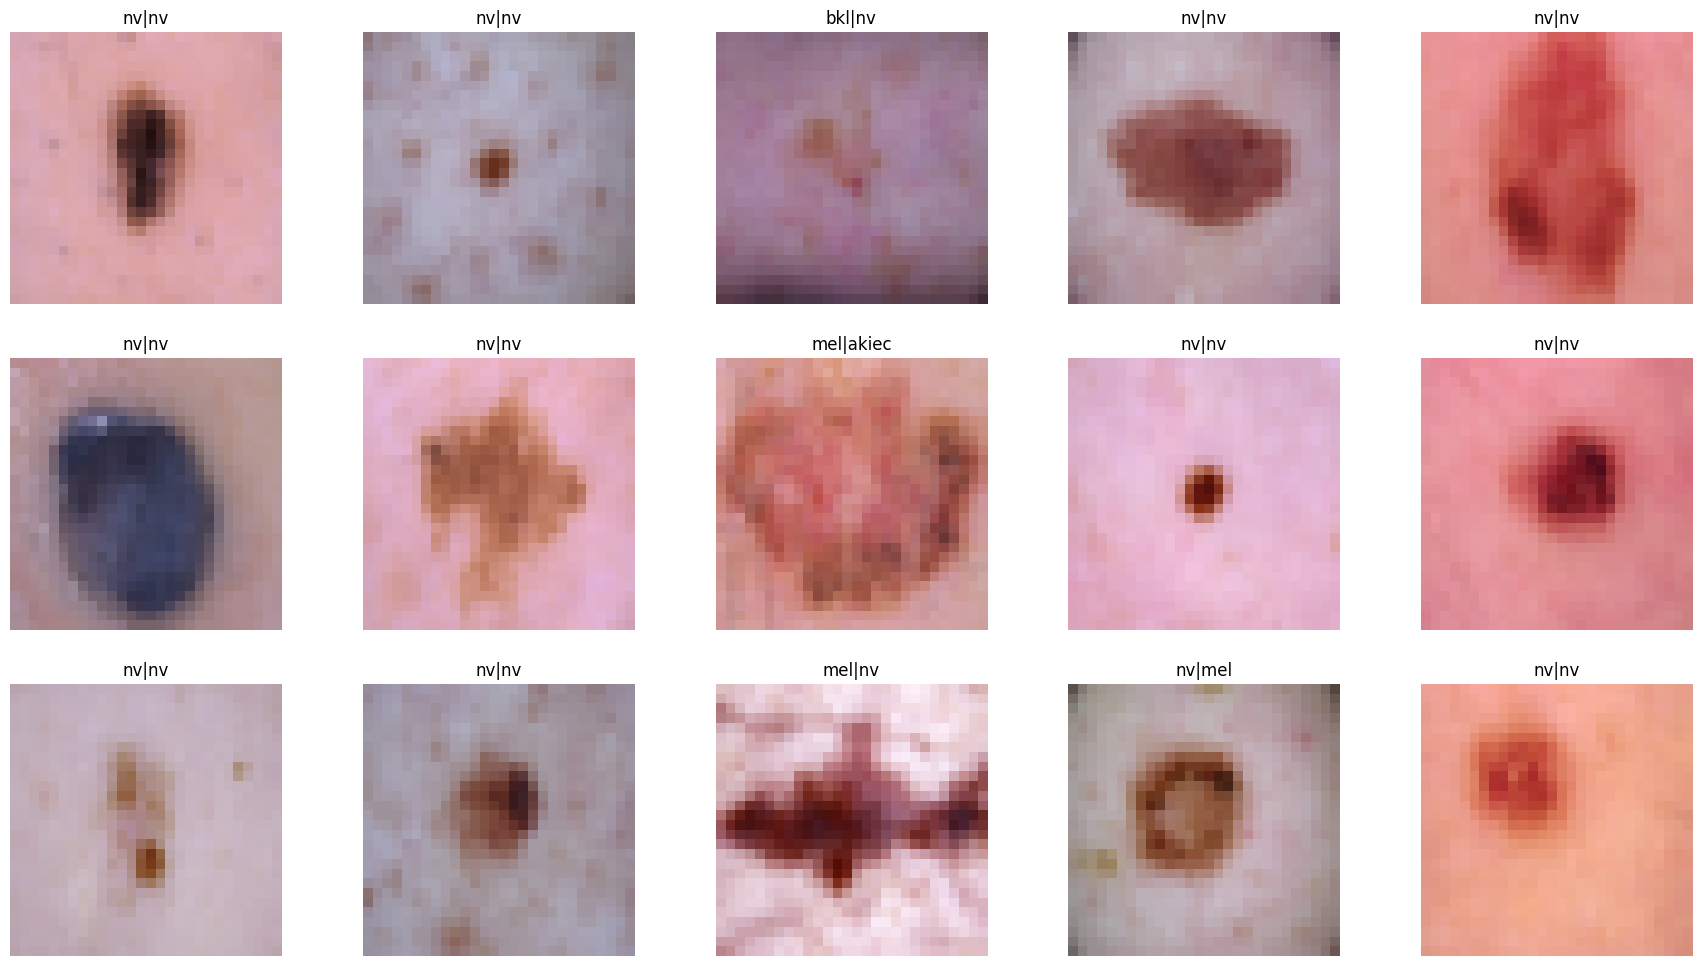

In [21]:
#For Original Dataset:

test_model(model1, X_test_orig, Y_test_orig)

Test Accuracy: 97.656%
266/266 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

          nv       0.98      0.88      0.93      1391
         mel       0.93      0.98      0.96      1080
         bkl       0.94      0.99      0.96      1141
         bcc       0.98      1.00      0.99      1238
       akiec       1.00      1.00      1.00      1153
        vasc       1.00      1.00      1.00      1270
          df       1.00      1.00      1.00      1217

    accuracy                           0.98      8490
   macro avg       0.98      0.98      0.98      8490
weighted avg       0.98      0.98      0.98      8490



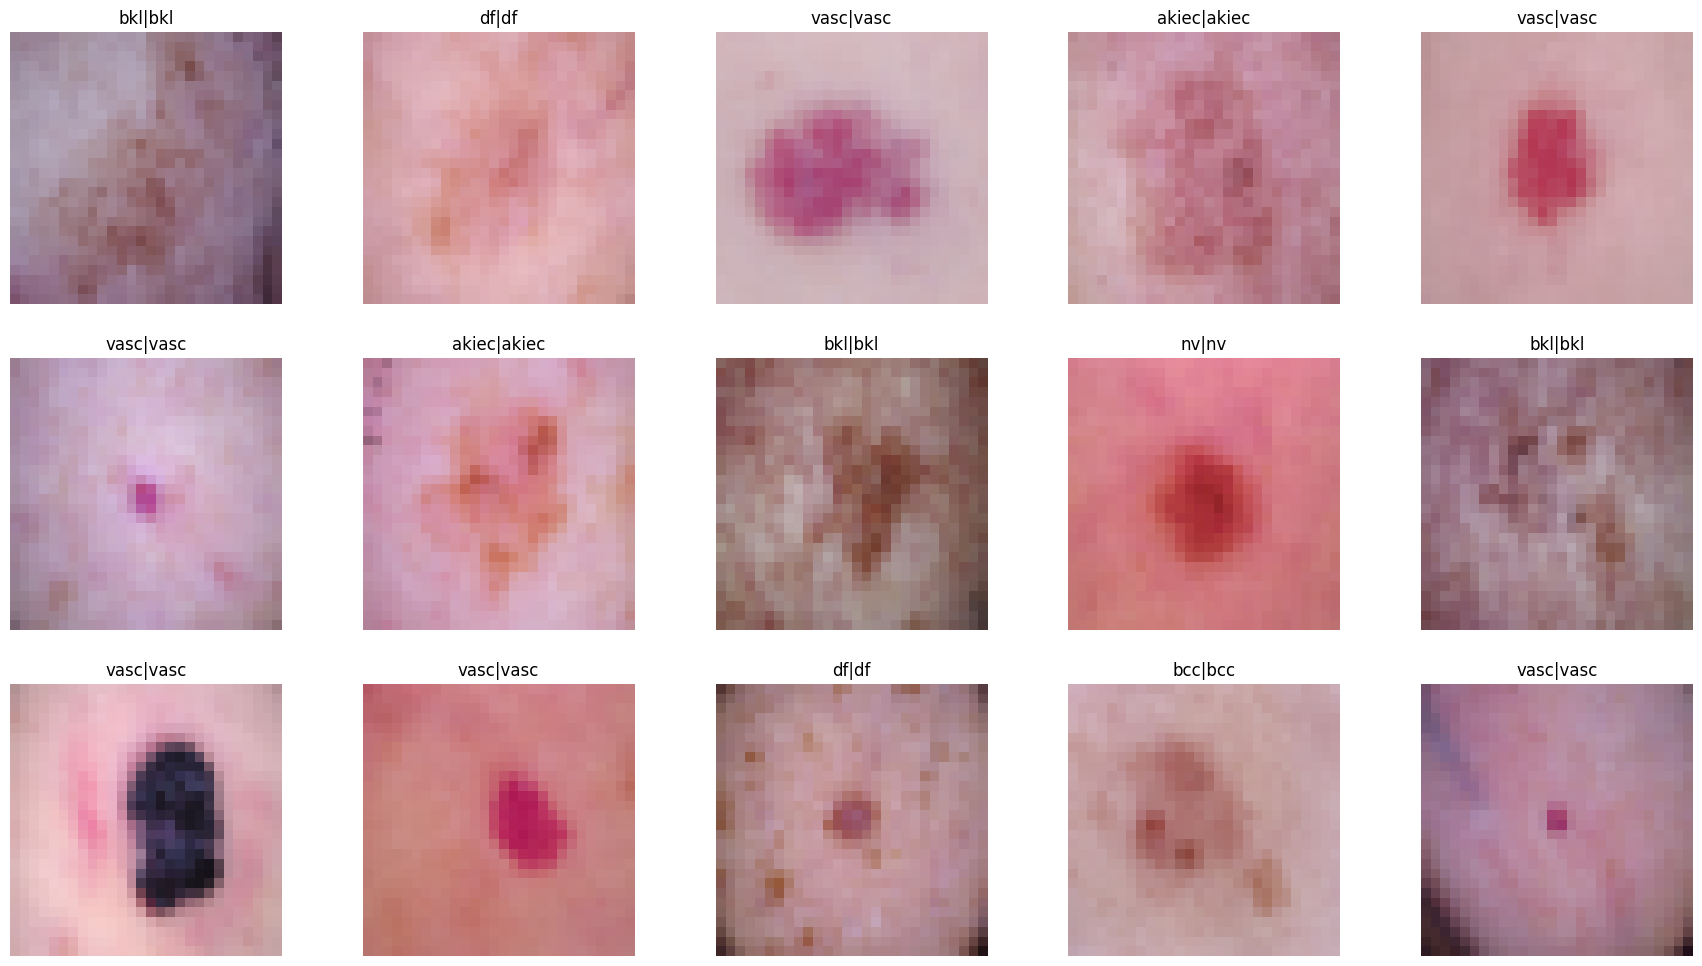

In [22]:

#For Augmented Dataset:
test_model(model2, X_test_aug, Y_test_aug)

9. Plotting Model Training Curve and Testing

In [23]:

#For Original Dataset:
plot_model_training_curve(model1_history)

In [24]:
#For Augmented Dataset:

plot_model_training_curve(model2_history)